# Обзор

В этом ноутбуке выполнено предварительное исследование временных рядов цен и объёмов для пар BTCUSDT и ETHUSDT на 4‑часовом таймфрейме. Основные шаги:

- Загрузка и нормализация данных OHLCV.
- Построение и проверка базовых графиков — цена, объём, лог-доходности, распределение доходностей, скользящая волатильность и автокорреляция.
- Генерация набора технических признаков: SMA/EMA, RSI, MACD, полосы Боллинджера, ATR, оценка волатильности Garman–Klass, лаги лог-доходностей, z‑score объёма, доля taker‑buy и другие микроструктурные признаки (если доступны столбцы).
- Очистка данных (удаление NaN в вновь созданных фичах) и разбиение по времени на train/valid/test в соотношении 70%/15%/15%.

Цель: получить чистые, временно упорядоченные датасеты с наборами фич для последующего моделирования и сравнительного анализа стратегий/машинного обучения.


In [1]:
import os
from turtle import Turtle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

DATA_DIRS = Path("./data")
OUT_DIR = Path("./output")
OUT_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_FRAC = 0.70
VALID_FRAC = 0.15
ACF_MAX_LAG = 30
# параметры индикаторов
RSI_PERIOD = 14
MACD_FAST=12
MACD_SLOW = 26
MACD_SIGNAL = 9
BB_PERIOD = 20
BB_K = 2.0
ATR_PERIOD = 14
GK_WINDOW = 42
VOL_Z_WINDOW = 30
RET_LAGS = [1, 6, 42, 180]

In [2]:
# Здесь вспомогательные функции + функции создания индикаторов, сплиты и т.д.

def find_csv_files():
    data_dir = DATA_DIRS
    candidates = []
    for fname in ("BTCUSDT_4h_full.csv", "ETHUSDT_4h_full.csv"):
        p = data_dir/fname
        if p.exists():
            candidates.append(p)
    return candidates

def read_ohlcv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    dt_col = "datetime"
    df[dt_col]=pd.to_datetime(df[dt_col], utc=True, errors="coerce")
    df = df.set_index(dt_col)
    df=df.rename(columns={c: c.lower() for c in df.columns}) # нормализуем имена
    drop_cols = [c for c in ["ignore", "open_time", "close_time"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    # убедимся, что базовые колонки есть
    needed = ["open", "high", "low", "close", "volume"]
    df["symbol"] = path.stem.split("_")[0].upper() # добавим тикер из имени файла
    return df

# Далее идут индикаторы

def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.clip(lower=0)).ewm(alpha=1/period, adjust=False).mean()
    loss = (-delta.clip(upper=0)).ewm(alpha=1/period, adjust=False).mean()
    rs = gain/(loss.replace(0, np.nan))
    return 100-(100/(1+rs))

def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def sma(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window=window, min_periods=window).mean()

def macd(series: pd.Series, fast=12, slow=26, signal=9):
    fast_ema = ema(series, fast)
    slow_ema = ema(series, slow)
    macd_line = fast_ema - slow_ema
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def bollinger_bands(series: pd.Series, window=20, k=2.0):
    mid = sma(series, window)
    std = series.rolling(window=window, min_periods=window).std()
    upper = mid+k*std
    lower = mid-k*std
    bandwidth = (upper - lower) / (mid.replace(0, np.nan).abs())
    pb = (series - lower) / (upper - lower)
    return mid, upper, lower, bandwidth, pb

def true_range(df: pd.DataFrame) -> pd.Series:
    prev_close = df["close"].shift(1)
    tr = pd.concat([
        (df["high"] - df["low"]).abs(),
        (df["high"] - prev_close).abs(),
        (df["low"] - prev_close).abs(),
    ], axis=1).max(axis=1)
    return tr

def atr(df: pd.DataFrame, period=14) -> pd.Series:
    tr = true_range(df)
    return tr.rolling(window=period, min_periods=period).mean()

def garman_klass_vol(df: pd.DataFrame, window=42) -> pd.Series:
     # ежедневная оценка волатильности по Garman-Klass, здесь адаптирована под 4h бары.
    # Формула (без дивидендов):
    # sigma^2 = 0.5*(ln(H/L))^2 - (2*ln(2)-1)*(ln(C/O))^2
    # Возвращаем rolling std (sqrt) по окну.
    log_hl = np.log(df["high"]/df["low"]).replace([np.inf, -np.inf], np.nan)
    log_co = np.log(df["close"] / df["open"]).replace([np.inf, -np.inf], np.nan)
    var = 0.5 * (log_hl**2) - (2*np.log(2) - 1) * (log_co**2)
    gk = var.rolling(window=window, min_periods=window).mean().clip(lower=0)
    return np.sqrt(gk)

# добавление индикаторов к датафрейму
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    close = out["close"]
    out["sma_20"] = sma(close, 20)
    out["ema_20"] = ema(close, 12)
    out["ema_20"] = ema(close, 26)
    out["rsi_14"] = rsi(close, 14)
    macd_line, macd_signal, macd_hist = macd(close, 12, 26, 9)
    out["macd"] = macd_line
    out["macd_signal"] = macd_signal
    out["macd_hist"] = macd_hist
    mid, up, lo, bw, pb = bollinger_bands(close, 20, 2.0)
    out["bb_mid"] = mid
    out["bb_up"] = up
    out["bb_lo"] = lo
    out["bb_bw"] = bw
    out["bb_pb"] = pb
    out["atr_14"] = atr(out, 14)
    out["gk_vol"] = garman_klass_vol(out, 42)
    # текущая лог-доходность - используем только для создания таргета
    out["ret_log"] = np.log(out["close"]).diff()
    out["y"] = out["ret_log"].shift(-1) # цель - доходность следующего 4-часового бара (shift-1)
    for L in [1, 6, 42, 180]:
        out[f"ret_log_lag{L}"] = out["ret_log"].shift(L)
    # Чтоб не было утечек, удаляем колонку с текущей доходностью
    if "ret_log" in out.columns:
        out = out.drop(columns=["ret_log"])
    out["range_frac"] = (out["high"] - out["low"])/out["close"].replace(0, np.nan)
    out["vol_z"] = (out["volume"] - out["volume"].rolling(30).mean())/out["volume"].rolling(30).std()
    # Микроструктурные признаки: 
    # (добавлены в последний момент, поэтому на всякий случай проверка на наличие)
    if "quote_volume" in out.columns and "volume" in out.columns:
        out["vwap"] = (out["quote_volume"] / out["volume"]).replace([np.inf, -np.inf], np.nan)
        out["vwap_diff_close"] = out["vwap"] - out["close"]
    if "trades" in out.columns and "volume" in out.columns:
        out["avg_trade_size"] = out["volume"] / out["trades"].replace(0, np.nan)
        out["avg_trade_size_z"] = (out["avg_trade_size"] - out["avg_trade_size"].rolling(30).mean()) / out["avg_trade_size"].rolling(30).std()
    if "taker_buy_base" in out.columns and "volume" in out.columns:
        out["taker_buy_frac"] = out["taker_buy_base"] / out["volume"].replace(0, np.nan)
    if "taker_buy_quote" in out.columns and "quote_volume" in out.columns:
        out["taker_buy_quote_frac"] = out["taker_buy_quote"] / out["quote_volume"].replace(0, np.nan)
    # временные фичи, могут улучшить точность TFT (заведомо известные в момент t)
    idx = out.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert(None)
    # простые признаки
    out["hour"] = idx.hour.astype("int8")
    out["day_of_week"] = idx.dayofweek.astype("int8")
    # циклическая кодировка sin/cos - важно для моделей, чувствительных к периодичности
    out["hour_sin"] = np.sin(2 * np.pi * out["hour"] / 24).astype("float32")
    out["hour_cos"] = np.cos(2 * np.pi * out["hour"] / 24).astype("float32")
    out["dow_sin"] = np.sin(2 * np.pi * out["day_of_week"] / 7).astype("float32")
    out["dow_cos"] = np.cos(2 * np.pi * out["day_of_week"] / 7).astype("float32")
    
    return out

def time_split(df: pd.DataFrame, train_frac=0.7, valid_frac=0.15):
    # возвращаем train, valid, test по времени, без перемешивания
    df = df.sort_index()
    n = len(df)
    i1 = int(n*train_frac)
    i2 = int(n*(train_frac+valid_frac))
    train=df.iloc[:i1]
    valid=df.iloc[i1:i2]
    test=df.iloc[i2:]
    return train, valid, test

def quick_acf(x: pd.Series, max_lag=30):
    # простая несмещённая ACF
    x = pd.Series(x).dropna()
    x = x - x.mean()
    var = (x**2).sum()
    acf_vals = [1.0]
    for k in range(1, max_lag+1):
        cov = (x[k:] * x.shift(k)[k:]).sum()
        acf_vals.append(float(cov / var) if var != 0 else np.nan)
    return np.array(acf_vals)

# В ходе первичного анализа были обнаружены разрывы, поэтому создадим функцию маркировки разрывов
def mark_time_gaps(df: pd.DataFrame, expected_hours: int = 4) -> pd.DataFrame:
    # добавляет колонки:
    #  - time_diff - разница во времени между текущим и предыдущим индексом;
    #  - time_gap - True, if разница != expected_hours;
    #  - is_regular - True, if интервал ровен 4 часам.
    #пепрвый индекс получает NaT в time_diff и is_regular=False.

    out = df.copy()
    expected = pd.Timedelta(hours=expected_hours)
    diffs = out.index.to_series().diff()
    out["time_diff"] = diffs
    out["time_gap"] = diffs != expected
    # is_regular: True только если diff == expected (NaT -> False)
    out["is_regular"] = (diffs == expected).fillna(False)
    return out


In [3]:
# здесь происходит загрузка данных
paths = find_csv_files()
print("Найдено файлов:", len(paths))
for p in paths:
    print(" -", p)

frames = {}
for p in paths:
    df = read_ohlcv(p)
    keep = [c for c in ["open","high","low","close","volume","quote_volume","trades","taker_buy_base","taker_buy_quote","symbol"] if c in df.columns]
    df = df[keep]
    df = mark_time_gaps(df, expected_hours=4) # метим разрывы

    # удаляем строки с странным интервалом
    df = df[~df["time_gap"].fillna(False)]
    frames[p.stem] = df

list(frames.keys()), {k: (v.index.min(), v.index.max(), len(v)) for k,v in frames.items()}

Найдено файлов: 2
 - data\BTCUSDT_4h_full.csv
 - data\ETHUSDT_4h_full.csv


(['BTCUSDT_4h_full', 'ETHUSDT_4h_full'],
 {'BTCUSDT_4h_full': (Timestamp('2017-08-17 08:00:00+0000', tz='UTC'),
   Timestamp('2024-12-31 20:00:00+0000', tz='UTC'),
   16136),
  'ETHUSDT_4h_full': (Timestamp('2017-08-17 08:00:00+0000', tz='UTC'),
   Timestamp('2024-12-31 20:00:00+0000', tz='UTC'),
   16136)})

EDA (exploratory data analysis) - первичное исследование данных: понять структуру, качество и "поведение" рядов перед моделированием.
Здесь мы проверим:
 1. Диапазон дат, пропуски, дубликаты индеков
 2. Построим базовые графики
 3. Посмотрим распределение лог-доходностей и простую волатильность
 4. Прикинем автокорреляцию лог-доходнотсей на 30 лагов.


### BTCUSDT_4h_full ###
лдиапазон дат: 2017-08-17 08:00:00+00:00 → 2024-12-31 20:00:00+00:00  (наблюдений: 16136)
Дубликатов индекса: 0
Доля пропусков (топ-10):
open               0.0
high               0.0
low                0.0
close              0.0
volume             0.0
quote_volume       0.0
trades             0.0
taker_buy_base     0.0
taker_buy_quote    0.0
symbol             0.0
dtype: float64


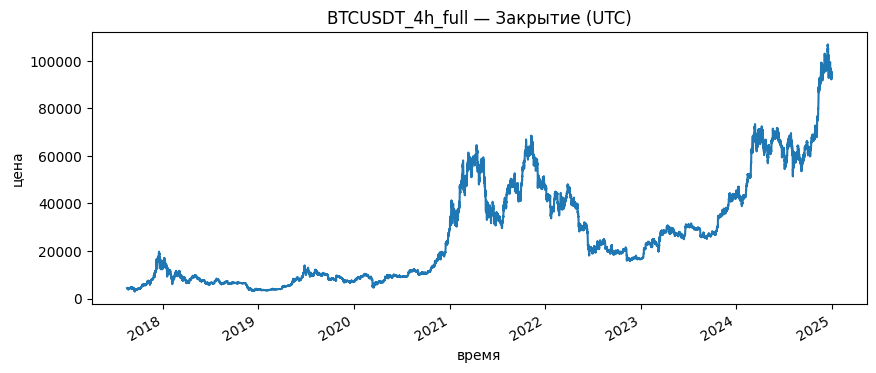

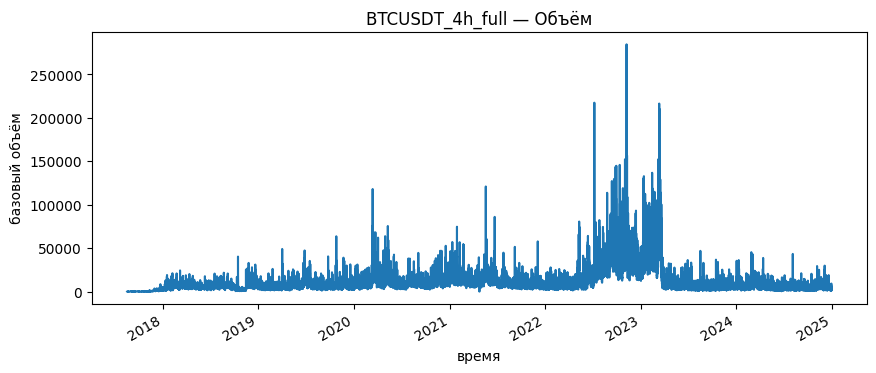

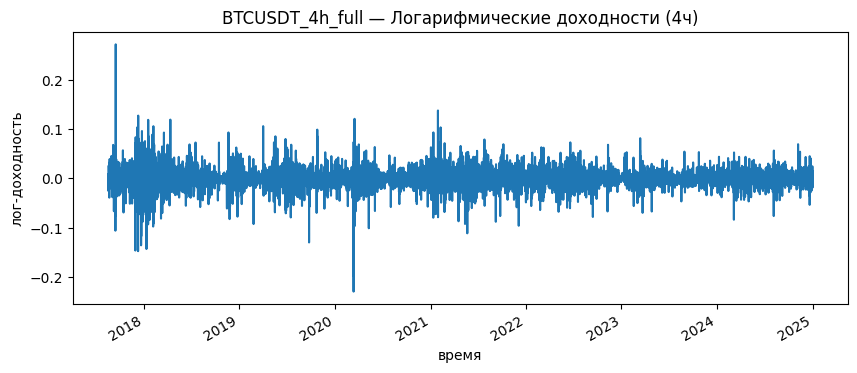

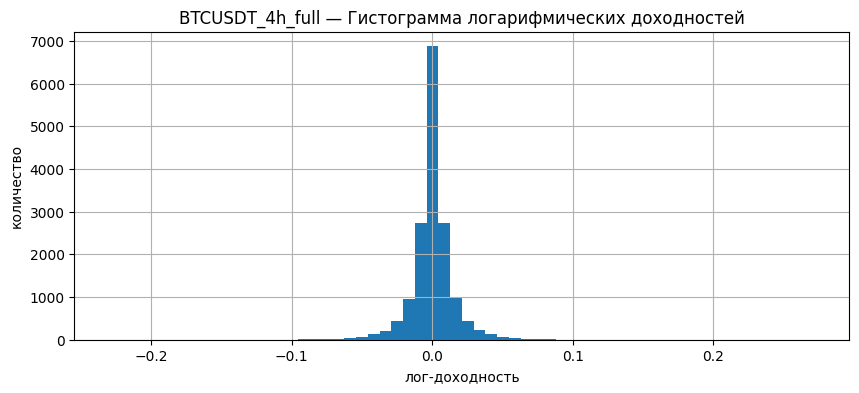

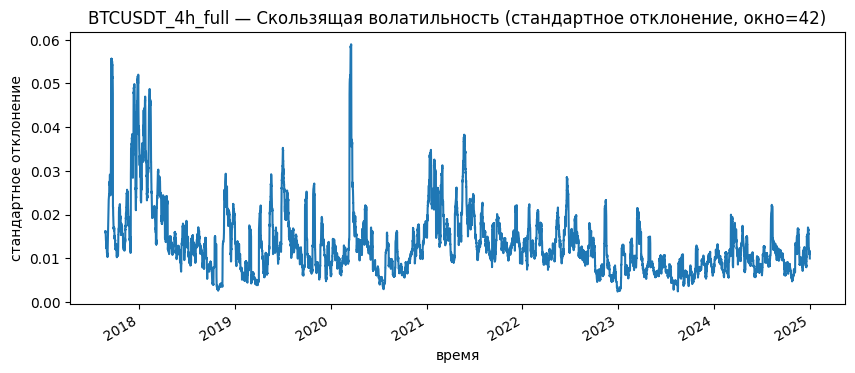

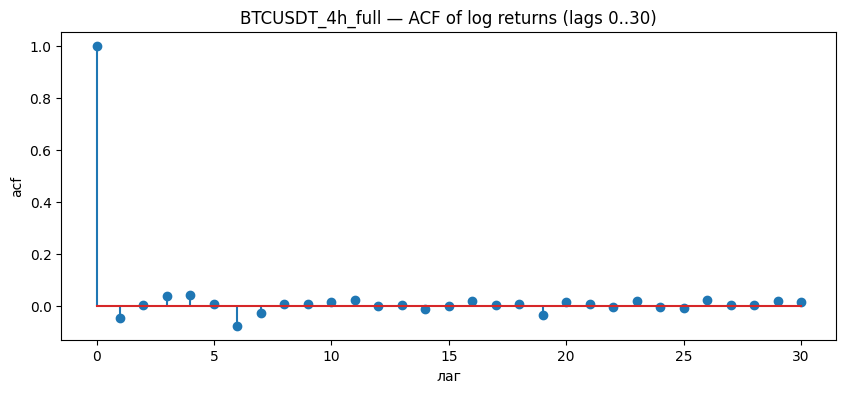


### ETHUSDT_4h_full ###
лдиапазон дат: 2017-08-17 08:00:00+00:00 → 2024-12-31 20:00:00+00:00  (наблюдений: 16136)
Дубликатов индекса: 0
Доля пропусков (топ-10):
open               0.0
high               0.0
low                0.0
close              0.0
volume             0.0
quote_volume       0.0
trades             0.0
taker_buy_base     0.0
taker_buy_quote    0.0
symbol             0.0
dtype: float64


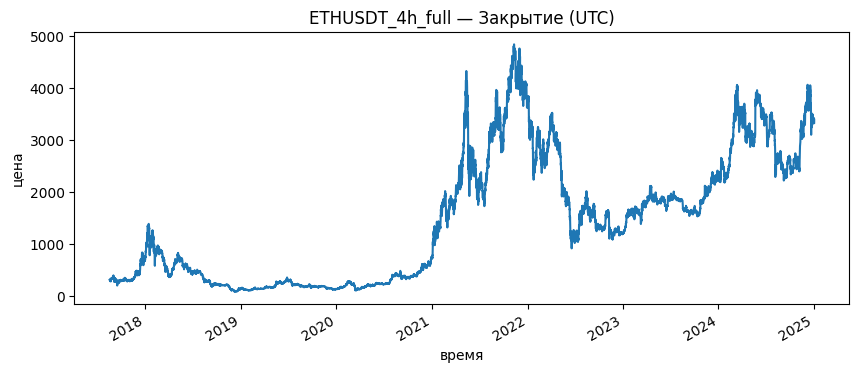

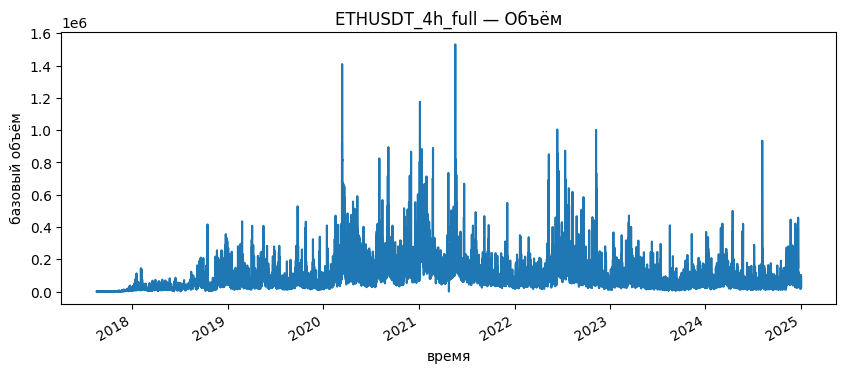

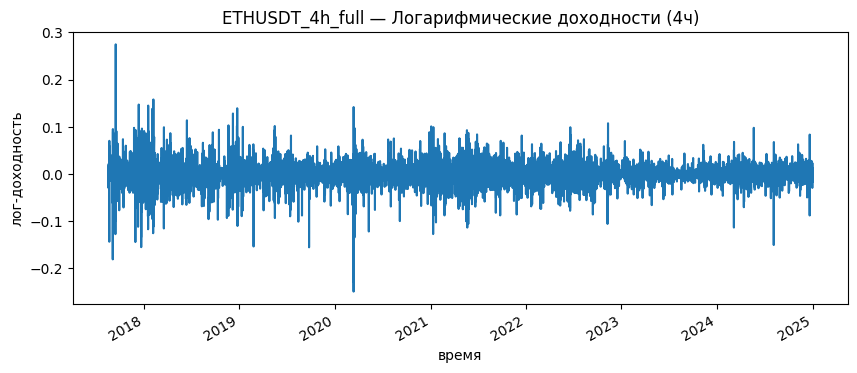

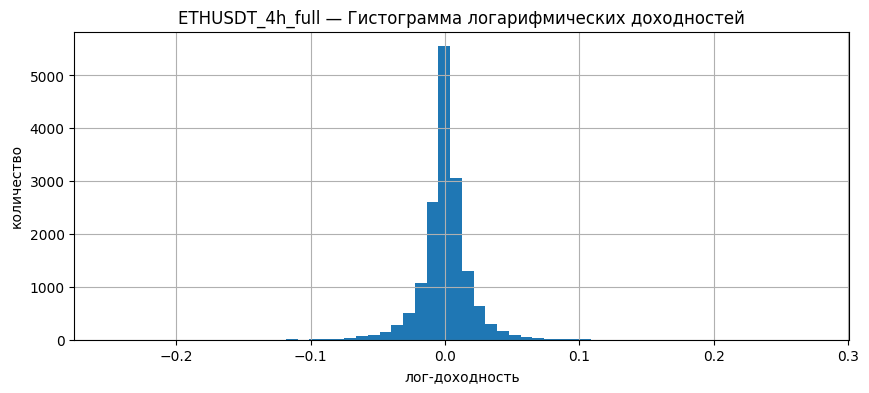

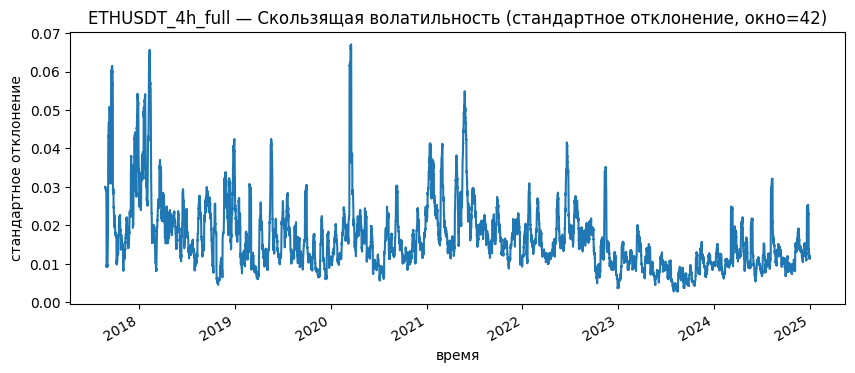

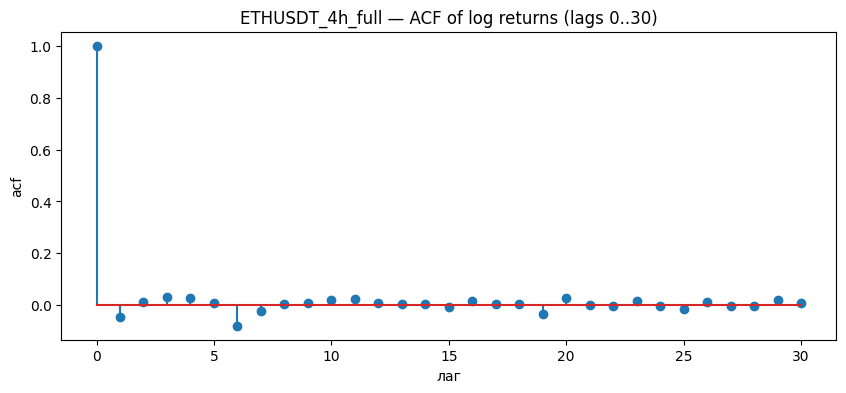

In [4]:
for name, df in frames.items():
    print("\n###", name, "###")
    # некое "резюме" датасета
    start, end = df.index.min(), df.index.max()
    dup_count = int(df.index.duplicated().sum())
    na_pct = df.isna().mean().sort_values(ascending=False).round(4)
    print(f"лдиапазон дат: {start} → {end}  (наблюдений: {len(df)})")
    print(f"Дубликатов индекса: {dup_count}")
    print("Доля пропусков (топ-10):")
    print(na_pct.head(10))

    # цена
    plt.figure()
    df["close"].plot(title=f"{name} — Закрытие (UTC)")
    plt.xlabel("время")
    plt.ylabel("цена")
    plt.show()

    # объёмы
    plt.figure()
    df["volume"].plot(title=f"{name} — Объём")
    plt.xlabel("время")
    plt.ylabel("базовый объём")
    plt.show()

    # лог-доходности и их распределение
    ret_log = np.log(df["close"]).diff()
    plt.figure()
    ret_log.plot(title=f"{name} — Логарифмические доходности (4ч)")
    plt.xlabel("время")
    plt.ylabel("лог-доходность")
    plt.show()

    plt.figure()
    ret_log.dropna().hist(bins=60)
    plt.title(f"{name} — Гистограмма логарифмических доходностей")
    plt.xlabel("лог-доходность")
    plt.ylabel("количество")
    plt.show()

    # рRolling-волатильность
    plt.figure()
    ret_log.rolling(42).std().plot(title=f"{name} — Скользящая волатильность (стандартное отклонение, окно=42)")
    plt.xlabel("время")
    plt.ylabel("стандартное отклонение")
    plt.show()

    # Быстрый ACF до 30 лагов
    acf_vals = quick_acf(ret_log, max_lag=30)
    plt.figure()
    plt.stem(range(len(acf_vals)), acf_vals)
    plt.title(f"{name} — ACF of log returns (lags 0..30)")
    plt.xlabel("лаг"); plt.ylabel("acf")
    plt.show()

In [5]:
feat_frames = {}
for name, df in frames.items():
    fx = add_indicators(df)
    # удалим строки с NaN по вновь созданным фичам (чтоб сплиты были чистыми)
    new_cols = [c for c in fx.columns if c not in df.columns]
    fx_clean = fx.dropna(subset=new_cols)
    feat_frames[name] = fx_clean
    print(name, "→ shape before/after:", df.shape, "→", fx_clean.shape)

# Покажем колонки (не все)
{k: list(v.columns)[:15] for k, v in feat_frames.items()}

BTCUSDT_4h_full → shape before/after: (16136, 13) → (15954, 45)
ETHUSDT_4h_full → shape before/after: (16136, 13) → (15954, 45)


{'BTCUSDT_4h_full': ['open',
  'high',
  'low',
  'close',
  'volume',
  'quote_volume',
  'trades',
  'taker_buy_base',
  'taker_buy_quote',
  'symbol',
  'time_diff',
  'time_gap',
  'is_regular',
  'sma_20',
  'ema_20'],
 'ETHUSDT_4h_full': ['open',
  'high',
  'low',
  'close',
  'volume',
  'quote_volume',
  'trades',
  'taker_buy_base',
  'taker_buy_quote',
  'symbol',
  'time_diff',
  'time_gap',
  'is_regular',
  'sma_20',
  'ema_20']}

In [6]:
splits = {}
for name, fx in feat_frames.items():
    train, valid, test = time_split(fx, train_frac=TRAIN_FRAC, valid_frac=VALID_FRAC)
    splits[name] = {"train": train, "valid": valid, "test": test}
    print(f"\n{name}:")
    print("  train:", train.index.min(), "-", train.index.max(), f"({len(train)})")
    print("  valid:", valid.index.min(), "-", valid.index.max(), f"({len(valid)})")
    print("  test :", test.index.min(),  "-", test.index.max(),  f"({len(test)})")


BTCUSDT_4h_full:
  train: 2017-09-16 20:00:00+00:00 - 2022-10-25 20:00:00+00:00 (11167)
  valid: 2022-10-26 00:00:00+00:00 - 2023-11-28 16:00:00+00:00 (2393)
  test : 2023-11-28 20:00:00+00:00 - 2024-12-31 16:00:00+00:00 (2394)

ETHUSDT_4h_full:
  train: 2017-09-16 20:00:00+00:00 - 2022-10-25 20:00:00+00:00 (11167)
  valid: 2022-10-26 00:00:00+00:00 - 2023-11-28 16:00:00+00:00 (2393)
  test : 2023-11-28 20:00:00+00:00 - 2024-12-31 16:00:00+00:00 (2394)


In [7]:
for name, fx in feat_frames.items():
    sym = str(fx["symbol"].iloc[0]).upper() if "symbol" in fx.columns else name
    # Единый файл с фичами
    fx.to_csv(OUT_DIR / f"{sym}_features.csv", index=True)
    # Отдельные сплиты
    s = splits[name]
    s["train"].to_csv(OUT_DIR / f"{sym}_train.csv", index=True)
    s["valid"].to_csv(OUT_DIR / f"{sym}_valid.csv", index=True)
    s["test"].to_csv(OUT_DIR / f"{sym}_test.csv", index=True)

print("Сохранено в ", OUT_DIR.resolve())

Сохранено в  C:\Users\User\Desktop\Исследование\output


#  Вывод
Границы по времени:

**train**: 2017‑09‑16 12:00 → 2022‑10‑25 12:00 UTC

**valid**: 2022‑10‑25 16:00 → 2023‑11‑28 16:00 UTC

**test**: 2023‑11‑28 20:00 → 2024‑12‑31 20:00 UTC

- Пропусков и дубликатов нет (NaN = 0 по всем колонкам; timestamp уникален и строго возрастает).
- Распределение лог-доходностей адекватное: среднее ≈0, std ~1.5–1.9% на 4ч, толстые хвосты и отрицательная асимметрия (типично для крипты).
- Пропусков и дубликатов нет (NaN = 0 по всем колонкам; timestamp уникален и строго возрастает).
- Волатильность сильно меняется во времени; периодически наблюдаются всплески (волатильность кластеризована), важно будет учитывать при моделировании.
- Автокорреляция лог-доходностей быстро убывает, нет выраженной долгосрочной автокорреляции (на 4‑часовом таймфрейме).
- Фичи: OHLCV+биржевые (quote_volume, trades, taker_buy_*), техиндикаторы (SMA/EMA, RSI, MACD(+hist), Bollinger (mid/up/lo, bw, pb), ATR, Garman–Klass), лаги доходности (ret_log_lag{1,6,42,180}), объёмные z-score, VWAP/разности, микроструктура (avg_trade_size, taker_buy_frac и т.п.) + временные признаки. Итого около 43 признаков на бар.